In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
import pylab as plt
from scipy import stats
import xlwings as xw

In [103]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/Temp/"
#path = "/Users/marf/Desktop/PhD Temp/2016-07-16/"
#path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 4410
files_end = 4706

In [104]:
# cup configuration
#cup_config = cycle_Sb
Sn_isotopes = ["112", "114", "115", "116", "117", "118", "119", "120", "122", "124"]
cup_config = cycles2

# Mass Range of cup configuration
mass_range = cycles2_mass_range

# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "125"}
corr_isotopes_2 = {"Cd" : "111", "Te" : "125", "Xe" : "129"}
#corr_isotopes_2 = {}
corr_isotopes_Sb = {"Te": "125"}

norm_ratio = ["122","118"]
denom_isotope = norm_ratio[1]
Sn_monitor = ["111", "113", "125"]


def eval_iso_list(isotopes_list,norm_ratio, monitor_iso):
    isotope_nom = norm_ratio[0]
    isotope_den = norm_ratio[1]
    isotopes_list.remove(norm_ratio[1])
    for i in range(len(monitor_iso)):
        isotopes_list.append(monitor_iso[i])
    isotopes_list.sort()
    return isotopes_list

isotope_ls = eval_iso_list(Sn_isotopes, norm_ratio, Sn_monitor)

data_sample_column = [(i + "/" + denom_isotope) for i in isotope_ls]    
isotopes = [isotope_ls]

#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = False
# background correction
blk_corr = True

In [105]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
files_1 = range(4410,4497,1) + range(4503,4545, 1)
for sample in files_1:
    
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_zero_2 = df_zero_2[columns_2]
    df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    #df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)

#for x in [123]:
#    sample_ls.remove(x)
#blk_ls = blk_ls[0::5]
#blk_ls.remove(5234)

In [106]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        #df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        #df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    #data_sample = new_corr.internal_norm_1(norm_ratio, denom_isotope, iter_beta)
    data_sample = new_corr.raw_ratios_corr(denom_isotope)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = new_corr.mad_outlier_rejection(data_sample)
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)

In [107]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_internal_sub["Cd/Sn"] = (df_internal_norm["111"]/12.722)/(df_internal_norm["118"]/24.223)
df_internal_sub["Te/Sn"] = (df_internal_norm["125"]/7.0509)/(df_internal_norm["118"]/24.223)
#df_internal_sub["Te/Sn"] = (df_internal_norm["126"]/18.952)/(df_internal_norm["118"]/24.223)
#df_internal_sub = df_internal_sub[df_internal_sub["118"] >= 7]
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [108]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SD2])
df_internal_norm_mean["sample"] = df_internal_sub[~df_internal_sub.index.duplicated(keep='first')]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_sub[~df_internal_sub.index.duplicated(keep='first')]["sample"]
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
#df_internal_norm_mean = df_internal_norm_mean[df_internal_norm_mean["118"] >= 7]
df_internal_norm_mean
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

,111/118,112/118,113/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2016-07-15 15:10:00,0.000007,0.036891,0.000008,0.025694,0.013379,0.583953,0.312425,0.359511,1.382985,0.201824,...,5.766148,18.456082,6.635162,25.524341,3.725024,4.779231,0.000380,0.000012,0.000071,NIST 200ppb
2016-07-15 15:23:00,0.000008,0.036885,0.000007,0.025690,0.013378,0.583927,0.312417,0.359523,1.383063,0.201847,...,5.714281,18.290550,6.575883,25.296990,3.692045,4.737111,0.000403,0.000015,0.000076,NIST 200ppb
2016-07-15 15:37:00,0.000008,0.036877,0.000008,0.025687,0.013377,0.583888,0.312409,0.359536,1.383166,0.201877,...,5.683417,18.192239,6.540773,25.162894,3.672725,4.712642,0.000375,0.000015,0.000071,NIST 200ppb
2016-07-15 15:51:00,0.000006,0.036881,0.000008,0.025691,0.013377,0.583902,0.312416,0.359550,1.383200,0.201885,...,9.950327,31.849578,11.451521,44.054374,6.430209,8.250952,0.000665,0.000012,0.000072,NIST 350ppb
2016-07-15 16:04:00,0.000007,0.036872,0.000008,0.025686,0.013377,0.583847,0.312396,0.359550,1.383276,0.201909,...,5.603196,17.936184,6.448962,24.810717,3.621620,4.647418,0.000385,0.000013,0.000074,NIST 200ppb
2016-07-15 16:29:00,0.000007,0.036877,0.000007,0.025687,0.013375,0.583872,0.312405,0.359542,1.383217,0.201892,...,5.519340,17.667243,6.352120,24.437653,3.567017,4.577136,0.000382,0.000014,0.000074,NIST 200ppb
2016-07-15 16:43:00,0.000009,0.036874,0.000006,0.025686,0.013376,0.583872,0.312407,0.359545,1.383234,0.201892,...,5.294842,16.948553,6.093768,23.443830,3.421926,4.391028,0.000379,0.000016,0.000077,NIST 200ppb + 0.440ppb Mo
2016-07-15 16:56:00,0.000006,0.036871,0.000009,0.025687,0.013374,0.583834,0.312397,0.359556,1.383324,0.201917,...,5.483742,17.553781,6.311564,24.282597,3.544546,4.548669,0.000378,0.000012,0.000074,NIST 200ppb
2016-07-15 17:10:00,0.000007,0.036875,0.000007,0.025687,0.013376,0.583871,0.312403,0.359544,1.383238,0.201895,...,5.302437,16.973080,6.102580,23.477834,3.426926,4.397474,0.000373,0.000014,0.000075,NIST 200ppb + 0.250ppb Pd


In [109]:
df_internal_norm_sample_sd = df_internal_norm_mean.groupby(df_internal_norm_mean["sample"]).agg([np.mean, SD2])
df_internal_norm_sample_sd

111/118                 112/118            \
                               mean           SD2      mean       SD2   
sample                                                                  
Allende bomb 1_1           0.000020  0.000000e+00  0.036787  0.000000   
J.W. bomb 1_1              0.000013  0.000000e+00  0.036831  0.000000   
J.W. bomb 1_2              0.000017  0.000000e+00  0.036834  0.000000   
Murchison bomb 1_1         0.000065  0.000000e+00  0.036770  0.000000   
Murchison bomb 1_2         0.000057  0.000000e+00  0.036817  0.000000   
NIST 200ppb                0.000007  1.559178e-06  0.036826  0.000051   
NIST 200ppb + 0.001ppb In  0.000008  0.000000e+00  0.036816  0.000000   
NIST 200ppb + 0.005ppb U   0.000008  5.310906e-07  0.036829  0.000031   
NIST 200ppb + 0.010ppb Cd  0.000036  0.000000e+00  0.036807  0.000000   
NIST 200ppb + 0.015ppb U   0.000009  0.000000e+00  0.036811  0.000000   
NIST 200ppb + 0.03ppb Cd   0.000061  4.690551e-07  0.036839  0.000043   
NIST 200ppb + 0.040ppb Cd  0.000070  0.000000e+00  0.036822  0.000000   
NIST 200ppb + 0.056ppb Zr  0.000044  1.121207e-04  0.039108  0.006262   
NIST 200ppb + 0.082ppb Rh  0.000007  1.459613e-06  0.036823  0.000033   
NIST 200ppb + 0.109ppb Ru  0.000008  5.697195e-08  0.036823  0.000017   
NIST 200ppb + 0.250ppb Pd  0.000007  1.016850e-06  0.036831  0.000064   
NIST 200ppb + 0.440ppb Mo  0.000008  3.339890e-07  0.036831  0.000064   
NIST 200ppb + ME           0.000059  1.814166e-06  0.036829  0.000028   
NIST 350ppb                0.000007  1.128197e-06  0.036832  0.000057   

                            113/118                 114/118            \
                               mean           SD2      mean       SD2   
sample                                                                  
Allende bomb 1_1           0.000008  0.000000e+00  0.025651  0.000000   
J.W. bomb 1_1              0.000007  0.000000e+00  0.025667  0.000000   
J.W. bomb 1_2              0.000007  0.000000e+00  0.025668  0.000000   
Murchison bomb 1_1         0.000009  0.000000e+00  0.025646  0.000000   
Murchison bomb 1_2         0.000008  0.000000e+00  0.025667  0.000000   
NIST 200ppb                0.000007  1.779656e-06  0.025665  0.000023   
NIST 200ppb + 0.001ppb In  0.000006  0.000000e+00  0.025659  0.000000   
NIST 200ppb + 0.005ppb U   0.000007  5.563972e-07  0.025666  0.000014   
NIST 200ppb + 0.010ppb Cd  0.000009  0.000000e+00  0.025660  0.000000   
NIST 200ppb + 0.015ppb U   0.000007  0.000000e+00  0.025657  0.000000   
NIST 200ppb + 0.03ppb Cd   0.000009  7.199652e-07  0.025677  0.000018   
NIST 200ppb + 0.040ppb Cd  0.000010  0.000000e+00  0.025672  0.000000   
NIST 200ppb + 0.056ppb Zr  0.002532  7.140041e-03  0.029185  0.009864   
NIST 200ppb + 0.082ppb Rh  0.000008  1.649304e-06  0.025665  0.000016   
NIST 200ppb + 0.109ppb Ru  0.000008  3.706186e-07  0.025664  0.000007   
NIST 200ppb + 0.250ppb Pd  0.000007  2.297584e-06  0.025667  0.000028   
NIST 200ppb + 0.440ppb Mo  0.000007  1.031683e-06  0.025666  0.000029   
NIST 200ppb + ME           0.000010  1.677906e-06  0.025674  0.000014   
NIST 350ppb                0.000008  9.299560e-07  0.025669  0.000026   

                            115/118                ...            122  \
                               mean       SD2      ...           mean   
sample                                             ...                  
Allende bomb 1_1           0.013358  0.000000      ...       2.027596   
J.W. bomb 1_1              0.013365  0.000000      ...       2.661112   
J.W. bomb 1_2              0.013367  0.000000      ...       2.488367   
Murchison bomb 1_1         0.013354  0.000000      ...       2.333823   
Murchison bomb 1_2         0.013363  0.000000      ...       2.336165   
NIST 200ppb                0.013368  0.000009      ...       3.159321   
NIST 200ppb + 0.001ppb In  0.013377  0.000000      ...       3.112859   
NIST 200ppb + 0.005ppb U   0.013369  0.000008      ...       3.179161   
NIST 200ppb

In [13]:
#df_internal_norm_mean.describe()


/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()


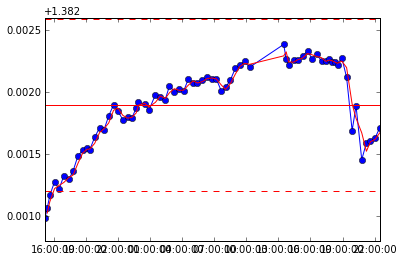

In [110]:
# variation of standard data + mean + 2SD
sel_ratio = "120/118"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].mean(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].mean()+ 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

In [ ]:
# variation of standard data + meadian + 25% quantile + 75% quantile
sel_ratio = "120/118"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].median(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].quantile(0.25), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].quantile(0.75), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

In [ ]:
# outlier corr variation of standard data + meadian + 25% quantile + 75% quantile
sel_ratio = "120/118"
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = new_corr.mad_outlier_rejection(plot_Nist.drop("sample", axis=1))
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plt.plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
plt.plot(plot_Nist.index, plot_Nist[sel_ratio], linestyle='-', marker='o', color='b')
plt.plot(plot_Nist.index, pd.rolling_mean(plot_Nist[sel_ratio], 2), linestyle='-', color='r')
plt.axhline(plot_Nist[sel_ratio].mean(), color='r', linestyle='-')
plt.axhline(plot_Nist[sel_ratio].mean()+ 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
#dataplot = plt.plot(plot_Nist.index, plot_Nist["120"], "ro")
plt.show()

In [111]:
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == "NIST 200ppb")].index
#corr_values = df_internal_norm_mean[(df_external_norm_mean >= 0.74289)]
#corr_values = df_internal_norm_mean[:"20150110 10:00"]
corr_values = df_internal_norm_mean[df_internal_norm_mean["118"] >= 1]
corr_values_2 = corr_values[corr_values["sample"] == "NIST 200ppb"]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]
std_mean = corr_values[(corr_values["sample"] == "NIST 100ppb")].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*1000
epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*1000
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != "NIST 200ppb"]
epsilon_2 = epsilon_2[epsilon_2["sample"] == "NIST 200ppb"]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
#epsilon_comp.index = epsilon_comp["Date"]
#epsilon_comp.columns
epsilon_comp = epsilon_comp.sort_index(axis=0)


In [50]:
epsilon_comp = epsilon_comp.drop([datetime.strptime("2016-12-20 21:53", "%Y-%m-%d %H:%M"),
                                  datetime.strptime("2016-12-20 20:15", "%Y-%m-%d %H:%M"),
                                  datetime.strptime("2016-12-20 20:55", "%Y-%m-%d %H:%M"),
                                       datetime.strptime("2016-12-21 01:50", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-21 02:30", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-21 03:29", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-21 08:06", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-21 09:04", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-21 12:31", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-21 17:21", "%Y-%m-%d %H:%M"),
                                  datetime.strptime("2016-12-21 21:37", "%Y-%m-%d %H:%M"),
                                    datetime.strptime("2016-12-21 21:51", "%Y-%m-%d %H:%M"),
                                  datetime.strptime("2016-12-21 22:06", "%Y-%m-%d %H:%M"),
                                       datetime.strptime("2016-12-21 22:36", "%Y-%m-%d %H:%M"), 
                                  datetime.strptime("2016-12-21 23:45", "%Y-%m-%d %H:%M"),
                                  datetime.strptime("2016-12-22 00:25", "%Y-%m-%d %H:%M"),
                                       datetime.strptime("2016-12-22 01:24", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-22 03:12", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-22 04:11", "%Y-%m-%d %H:%M"), 
                                       datetime.strptime("2016-12-22 05:20", "%Y-%m-%d %H:%M")])
epsilon_comp

,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2016-12-20 19:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 100ppb
2016-12-20 20:00:00,-5986.209764,-0.033354,-13347.564020,0.050868,-0.199751,-0.026385,-0.041540,-0.012793,-0.011740,0.008069,...,1089.197218,1089.234964,1089.238451,1089.265952,1089.286656,1089.317903,1062.423207,-3487.335349,-45.129548,NIST 200ppb
2016-12-20 20:29:00,-9272.519676,0.263767,-1594.124900,0.280502,0.016861,0.089306,0.065071,0.042616,0.013689,-0.059825,...,1088.448573,1088.399855,1088.336439,1088.310155,1088.183841,1088.109968,1347.231890,-4333.117707,102.018385,NIST 200ppb
2016-12-20 21:09:00,-1205.608754,0.051226,-738.537597,0.025961,0.034381,-0.056333,-0.044852,-0.033263,-0.018384,0.021612,...,0.997671,1.012162,1.026334,1.045691,1.068337,1.109735,63.598896,-1232.468080,59.996184,NIST 100ppb
2016-12-20 21:24:00,-951.317304,0.098688,-594.784528,0.234456,0.093829,0.072636,0.055758,0.038251,0.003470,-0.034254,...,-3.388236,-3.405636,-3.440175,-3.443835,-3.480637,-3.507655,-36.776564,-951.298310,-33.758859,NIST 100ppb
2016-12-20 21:39:00,1192.690269,-0.078163,-2861.906430,-0.206953,-0.180851,-0.065866,-0.057229,-0.039799,0.000294,0.045630,...,-4.210284,-4.193112,-4.153279,-4.153556,-4.103999,-4.078280,-57.226808,1192.823451,-52.172499,NIST 100ppb
2016-12-21 02:04:00,-467.658786,0.207518,-839.551382,0.131810,-0.063284,0.077119,0.051362,0.036308,0.003161,-0.047037,...,1078.530688,1078.499638,1078.430643,1078.424189,1078.323265,1078.265387,912.915423,-467.683347,-80.155890,NIST 200ppb
2016-12-21 02:44:00,-208.785355,0.072949,300.140424,0.096273,-0.065557,-0.014269,-0.018362,0.004845,0.005429,0.008563,...,-7.739412,-7.719837,-7.719478,-7.724469,-7.717060,-7.712993,-80.116742,-208.786196,-73.444893,NIST 100ppb
2016-12-21 02:59:00,400.956053,-0.092447,1646.993571,-0.249096,0.008060,0.000590,0.015375,-0.001383,-0.006116,-0.009374,...,10.355855,10.343113,10.337137,10.347082,10.338771,10.342610,91.477122,400.957579,81.630717,NIST 100ppb


In [112]:
def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

epsilon = epsilon_comp.drop(["111", "125", "112", "114", "115", "116", "117", "118", "119", "120", "122", "124", "Cd/Sn", "Te/Sn"], axis = 1)
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2]), decimals=2)
epsilon_sum

111/118          112/118       113/118          \
                              mean      SD2    mean   SD2    mean     SD2   
sample                                                                      
Allende bomb 1_1           2283.74      NaN   -0.43   NaN  214.86     NaN   
J.W. bomb 1_1               931.93      NaN   -0.70   NaN  115.42     NaN   
J.W. bomb 1_2              1005.51      NaN   -0.35   NaN  -86.36     NaN   
Murchison bomb 1_1         8679.58      NaN   -1.51   NaN  248.47     NaN   
Murchison bomb 1_2         7971.39      NaN   -0.76   NaN  294.76     NaN   
NIST 200ppb                   3.55   179.19   -0.00  0.37    3.36  232.36   
NIST 200ppb + 0.001ppb In    39.99      NaN    0.03   NaN   71.90     NaN   
NIST 200ppb + 0.005ppb U     55.15   179.01    0.06  0.12  -60.97  442.21   
NIST 200ppb + 0.010ppb Cd  4238.75      NaN   -0.06   NaN   99.32     NaN   
NIST 200ppb + 0.015ppb U     42.41      NaN    0.06   NaN  -84.61     NaN   
NIST 200ppb + 0.03ppb Cd   6803.08  1350.20    0.12  0.04  339.83  690.14   
NIST 200ppb + 0.040ppb Cd  7297.03      NaN    0.13   NaN  641.07     NaN   
NIST 200ppb + 0.056ppb Zr  -318.19   941.00    2.14  5.90  -90.76   75.55   
NIST 200ppb + 0.082ppb Rh   -52.08    43.79   -0.04  0.11   67.64   62.28   
NIST 200ppb + 0.109ppb Ru    -3.04   246.39    0.06  0.05   10.81   28.81   
NIST 200ppb + 0.250ppb Pd    33.00   133.52    0.00  0.13  -66.54  265.02   
NIST 200ppb + 0.440ppb Mo   149.36   175.24    0.01  0.15  -44.15  418.51   
NIST 200ppb + ME           8674.33  4360.19    0.10  0.21  245.63  103.64   
NIST 350ppb                 -40.35   140.51    0.06  0.14   74.73  179.26   

                          114/118       115/118         ...   120/118        \
                             mean   SD2    mean   SD2   ...      mean   SD2   
sample                                                  ...                   
Allende bomb 1_1            -0.12   NaN   -0.47   NaN   ...      0.13   NaN   
J.W. bomb 1_1               -0.47   NaN   -0.64   NaN   ...      0.23   NaN   
J.W. bomb 1_2               -0.26   NaN   -0.39   NaN   ...      0.12   NaN   
Murchison bomb 1_1          -0.70   NaN   -1.02   NaN   ...      0.50   NaN   
Murchison bomb 1_2          -0.26   NaN   -0.57   NaN   ...      0.22   NaN   
NIST 200ppb                 -0.00  0.26    0.00  0.18   ...     -0.00  0.12   
NIST 200ppb + 0.001ppb In   -0.04   NaN    0.84   NaN   ...      0.01   NaN   
NIST 200ppb + 0.005ppb U     0.01  0.12    0.08  0.10   ...     -0.02  0.01   
NIST 200ppb + 0.010ppb Cd    0.10   NaN   -0.07   NaN   ...      0.02   NaN   
NIST 200ppb + 0.015ppb U    -0.00   NaN   -0.10   NaN   ...     -0.02   NaN   
NIST 200ppb + 0.03ppb Cd     0.35  0.09    0.01  0.00   ...     -0.02  0.05   
NIST 200ppb + 0.040ppb Cd    0.45   NaN   -0.05   NaN   ...     -0.01   NaN   
NIST 200ppb + 0.056ppb Zr    1.41  3.88    0.99  2.80   ...     -0.73  2.05   
NIST 200ppb + 0.082ppb Rh    0.01  0.09    0.01  0.06   ...      0.01  0.04   
NIST 200ppb + 0.109ppb Ru    0.05  0.14    0.04  0.07   ...     -0.01  0.01   
NIST 200ppb + 0.250ppb Pd   -0.01  0.13    0.10  0.14   ...     -0.02  0.06   
NIST 200ppb + 0.440ppb Mo   -0.06  0.05    0.08  0.09   ...     -0.02  0.05   
NIST 200ppb + ME             0.36  0.19    0.01  0.15   ...     -0.01  0.07   
NIST 350ppb                  0.08  0.14    0.06  0.17   ...     -0.02  0.06   

                          122/118       124/118       125/118          \
                             mean   SD2    mean   SD2    mean     SD2   
sample                                                                  
Allende bomb 1_1             0.26   NaN    0.40   NaN   -7.19     NaN   
J.W. bomb 1_1                0.41   NaN    0.58   NaN   85.17     NaN   
J.W. bomb 1_2                0.19   NaN    0.30   NaN   11.21     NaN   
Murchison bomb 1_1           1.00   NaN    1.46   NaN  199.62     NaN   
Murchison bomb 1_2           0.43   NaN    0.62   NaN  125.70     NaN   
NIST 200p

In [54]:
sel_ratio = "112/118"
std = "NIST 100ppb"

def plot_epsilon(sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title("samples" + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\delta^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

In [47]:
wb = xw.books.add()
#wb.sheets.add()
wb.sheets["Sheet1"].range('A1').value = df_all
df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).mean()
df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
wb.sheets["Sheet1"].range('A344').value = df_all_mean

AttributeError: 'module' object has no attribute 'books'

In [69]:
#wb.sheets.add()
wb.sheets[3].range('AF1').value = df_internal_sub
#df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).mean()
#df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
#xw.Range('A344').value = df_all_mean

In [70]:
#wb.sheets.add()
wb.sheets[4].range('A21').value = df_internal_norm_mean_sd

In [71]:
wb.sheets[4].range('BF21').value = epsilon_comp

In [72]:
#epsilon_comp[epsilon_comp["sample"]== "NIST 200ppb"]["117/118"].std()
wb.sheets[4].range('BF36').value = epsilon_sum

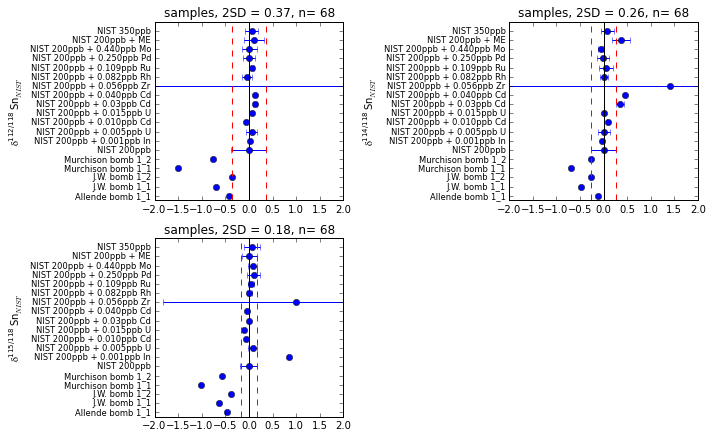

In [114]:
#sel_ratio = ["116/118", "117/118", "119/118", "120/118", "122/118", "124/118"]
#sel_ratio = ["116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]
#sel_ratio = ["112/120", "114/120", "115/120"]
sel_ratio = ["112/118", "114/118", "115/118"]
xlim = [-2, 2]

fig = plt.figure(figsize=(10,15))

for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST 200ppb", xlim)
fig.tight_layout()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
savefig(path+"delta_x_bgd_118_1.pdf", bbox_inches='tight')

In [ ]:
sel_ratio = "116/118"
epsilon_comp = epsilon_comp[epsilon_comp["sample"] == "NIST 200ppb"]
x = epsilon_comp.index
plt.plot(x, epsilon_comp[sel_ratio], marker="o")
plt.ylim([-0.5, 0.5])
#plt.xticks(x, epsilon_comp["sample"], size='small', rotation=90)
plt.axhline(epsilon_comp[sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[sel_ratio].mean()+ 2*epsilon_comp[sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[sel_ratio].mean()- 2*epsilon_comp[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{118}}$Sn')
#savefig(path+"epsilon_119.pdf", bbox_inches='tight')

In [35]:
df_all.to_csv(path + "Sn_H8_L4_2_cycles_NU_Signals_zero_corr.csv", mode='w', header=True)

In [115]:
df_internal_norm.to_csv(path + "Sn_H8_L4_2_cycles_raw_ratios_120_bdg_corr_all.csv", mode='w', header=True)

In [116]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_raw_ratios_120_bdg_corr.csv", mode='w', header=True)

In [ ]:
df_std.to_csv(path_sav + "All_standards_internal_norm_mean.csv")

In [ ]:
df_all_mean_1 = pd.read_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv")

In [ ]:
df_all_mean_2 = pd.read_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm_mean.csv")

In [ ]:
df_mean_all = df_all_mean_1.append(df_all_mean_2)

In [ ]:
#old Cd/Sn & Te/Sn extraction - doesn't include bgd corr
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_all_sub = df_all[(df_all["sample"] != "blank sol") & (df_all["sample"] != "SQ") & (df_all["sample"] != "teflon blank")]
df_internal_sub["111"] = df_all_sub["L3 (1)"]
df_internal_sub["125"] = df_all_sub["H5 (2)"]
df_internal_sub["Cd/Sn"] = (df_all_sub["L3 (1)"]/12.722)/(df_all_sub["H4 (1)"]/24.223)
df_internal_sub["Te/Sn"] = (df_all_sub["H5 (2)"]/7.0509)/(df_all_sub["H4 (1)"]/24.223)
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [ ]:
df_mean_all = df_mean_all[2:]
df_mean_all.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
df_mean_all = df_mean_all[["Date", "112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118","sample"]]
df_mean_all = df_mean_all.set_index("Date") 

In [ ]:
df_std = df_mean_all[(df_mean_all["sample"] == "SPEX1 100ppb") | (df_mean_all["sample"] == "SPEX 100ppb") | (df_mean_all["sample"] == "NIST 100ppb")]
df_std

In [ ]:
df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]] = df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]].astype(float)
df_std.index = df_std.index.astype(datetime64)
df_std = df_std[(df_std.index < pd.Timestamp('2015-03-10')) | (df_std.index > pd.Timestamp('2015-03-12'))]
df_std = df_std[(df_std.index < pd.Timestamp('2014-11-29 18:25:00')) | (df_std.index > pd.Timestamp('2014-11-29 20:27:00'))]
df_std

In [ ]:
df_std = df_std[(df_std["118"] > 5) & (df_std["118/120"] > 0.7428)]
for i in df_std.index[df_std["sample"] == "SPEX1 100ppb"]:
    df_std.ix[i, "sample"] = "SPEX 100ppb"

In [ ]:
sample = df_std["sample"]
std_mean = df_std[(df_std["sample"] == "SPEX 100ppb")].mean()
new = df_std[df_std.columns[df_std.dtypes != 'object']]
epsilon =  ((new / std_mean)-1)*10000
epsilon["sample"] = sample
epsilon
epsilon[(epsilon["118/120"] > 0.4) | (epsilon["118/120"] < -0.4)]

In [ ]:
lee = pd.DataFrame({"112/120" : pd.Series(0.029812), "114/120" : pd.Series(0.020195), "115/120": pd.Series(0.010366), "116/120": pd.Series(0.4460), "117/120" : pd.Series(0.235313), "118/120" : pd.Series(0.742935), "119/120" : pd.Series(0.263430), "122/120" : pd.Series(0.142086), "124/120" : pd.Series(0.177588)})
epsilon_lee = ((lee / std_mean[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]])-1)*10000
epsilon_lee["sample"] = "Lee et al. (1995)"
epsilon_lee